# Creation of dataframe for gravity model

- join on cityname
- create city dataframe (nodes)
- create separate city-pairs dataframes (basically edges)
- calculate distances

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import re
from tqdm.notebook import tqdm
import unidecode
from collections import Counter
from shapely.geometry import Point, LineString, Polygon

In [2]:
INDIR = "../../input"
OUTDIR = "../../output"
DATADIR = "../../../../data"
FILE_cities = "List_of_cities_300k.csv"
FILE_coords = "euro-global-map-shp/data/FullEurope/BuiltupP.shp" #path/to/shapefile

In [4]:
# load citylist
list_of_cities = pd.read_csv(os.path.join(INDIR, FILE_cities), sep=";")
list_of_cities.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,EU15,Code_Country,NUTS_1,NUTS_2,NUTS_3,...,PUR,Supra_poly_fua,PIA,Name_supra_poly_fua,Poly_fua,id_poly_fua,Name_poly_fua,SizeHinterland1k,GDP_per_capita,Dummy_Capital
0,FR00810,Paris,Paris,Paris,9591,1,FR,FR1,FR10,FR101,...,,0,PIA_Paris,99,0,,,1201,44,1
1,UK01886,London,London,Londres,8256,1,UK,UKI,UKI1,UKI11,...,,0,PIA_London,99,0,,,2752,45,1
2,ES00540,Madrid,Madrid,Madrid,4955,1,ES,ES3,ES30,ES300,...,,0,PIA_Madrid,99,0,,,308,29,1
3,DE00219,Berlin,Berlin,Berlin,3776,1,DE,DE3,DE30,DE300,...,,0,PIA_Berlin,99,0,,,240,22,1
4,IT01156,Milano,Milan,Milan,3698,1,IT,ITC,ITC4,ITC45,...,Milano,0,PIA_Milano,99,1,IT03,Milano metropolitan area,604,35,0


## Select relevant coordinates

In [4]:
built_up_complete = gpd.read_file(os.path.join(DATADIR, FILE_coords))

In [5]:
built_up_complete.head(5)

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1,1,_EG.EGM.BuiltupP:40c2730a-3a4b-474b-8f55-615cd...,20220125104612,AL020,MD,Cernoleuca,UNK,Cernoleuca,UNK,rum,UNK,1771,-32768,-32768,3,N.MD.BUILTUP.000823,POINT (27.56031 48.31269)
1,2,1,_EG.EGM.BuiltupP:f90e3db3-2ef5-4cf7-95ba-2f99f...,20220125104612,AL020,MD,Mo?ana,UNK,Mosana,UNK,rum,UNK,1630,-32768,-32768,3,N.MD.BUILTUP.000825,POINT (27.68990 48.32328)
2,3,1,_EG.EGM.BuiltupP:d947c478-818e-41ed-91a2-0aa79...,20220125104612,AL020,MD,Gribova,UNK,Gribova,UNK,rum,UNK,2101,-32768,-32768,3,N.MD.BUILTUP.000831,POINT (27.93089 48.01388)
3,4,1,_EG.EGM.BuiltupP:0f9b7f83-5249-4030-9933-417ed...,20220125104612,AL020,MD,Chirca,UNK,Chirca,UNK,rum,UNK,1704,-32768,-32768,3,N.MD.BUILTUP.000838,POINT (29.10819 46.92171)
4,5,1,_EG.EGM.BuiltupP:0e4be3d7-1937-4614-a7fd-f6bd2...,20220125104612,AL020,MD,Delac?u,UNK,Delacau,UNK,rum,UNK,2126,-32768,-32768,3,N.MD.BUILTUP.000840,POINT (29.30339 47.09902)


In [6]:
built_up_complete.shape

(72846, 18)

In [7]:
built_up = built_up_complete

In [8]:
built_up.shape

(72846, 18)

In [9]:
muas = list(list_of_cities.Mua)

In [10]:
mua_dict = dict()

for index, row in list_of_cities.iterrows():
    if row['Code_Country'] == 'UK': 
        mua_dict[row['Mua']] = 'GB'
    else: 
        mua_dict[row['Mua']] = row['Code_Country']
    

### Names with issues:

At least some of these non matches are combined cities. For these it is probably easiest to choose the coordinates of one. (although i guess the best option would be to calculate the midpoint between the combined cities and then take that);

Another problem is that unidecode replaces 'ü' with 'u' while the `NAMA1` variable lists this with 'ue'. Same for 'oe'.

Den Haag --> 's-Gravenhage (den Haag listed as NAMA2)

**Manual edits**

Antwerp listed with its dutch/flemish name Antwerpen. Brussels as Brussel

Don't understand what is happening to Lyon and Marseille. (listed only with arrondissement numbers in name, e.g. 'Lyon 1er Arrondissement')

error for Gent (negative population number)  
Sofia should be done manually as well (other Sofias are present but Sofia, BU is listed as 'S?fiya')

Stoke --> Stoke-on-Trent
Belfast cause country code does not match

Plovdiv --> Pl?vdiv

Wuppertal not in the dataset. 

suggested process:
1. un-decoded (so with accents). match to NAMA1 first. 
2. Then new list with left over cities, match to NAMN1 (for the umlauts).
3. left-over match to NAMN2
4. Manually match remaining cities




In [11]:
cities = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        cities.append(row['NAMA1'])
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        cities.append(row['NAMN1'])
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        cities.append(row['NAMN2'])

In [12]:
len(cities)

137

In [13]:
city_counts = Counter(cities) 
for key in city_counts:
    if city_counts[key] > 1:
        print(key)

Bremen
Leeds


In [14]:
# cities not automatically matched
leftovers = []
for city in muas:
    if city not in cities:
        leftovers.append(city)

In [15]:
# length of complete list - length of initial 'matches'
print(len(muas) - len(cities))

# length unmatched cities
print(len(leftovers))

14
16


In [16]:
leftovers

['Brussels',
 'Kobenhavn',
 'Lyon',
 'Sofia',
 'Essen-Oberhausen',
 'Marseille',
 'Antwerp',
 'Bochum-Herne',
 'Gelsenkirchen-Bottrop',
 'Belfast',
 'Palma de Mallorca',
 'Wuppertal',
 'Castellammare di Stabia-Torre Annunziata',
 'Plovdiv',
 'Alicanta',
 'La Coruna']

In [17]:
manual_names_v = {"Pl?vdiv":"Plovdiv", 
                "S?fiya":"Sofia", 
                "Koebenhavn": "Kobenhavn", 
                "Brussel": "Brussels", 
                "Antwerpen": "Antwerp",
                "A Coruna": "La Coruna", 
                "Alacant/Alicante": "Alicanta", 
                "Lyon 1er Arrondissement": "Lyon", 
                "Marseille 1er Arrondissement": "Marseille", 
                "Mallorca": "Palma de Mallorca"}

In [18]:
# add one of the compound cities to the dictionary
for city in leftovers:
    if '-' in city:
        manual_names_v[city.split('-')[0]] = city

In [19]:
manual_names_v

{'Pl?vdiv': 'Plovdiv',
 'S?fiya': 'Sofia',
 'Koebenhavn': 'Kobenhavn',
 'Brussel': 'Brussels',
 'Antwerpen': 'Antwerp',
 'A Coruna': 'La Coruna',
 'Alacant/Alicante': 'Alicanta',
 'Lyon 1er Arrondissement': 'Lyon',
 'Marseille 1er Arrondissement': 'Marseille',
 'Mallorca': 'Palma de Mallorca',
 'Essen': 'Essen-Oberhausen',
 'Bochum': 'Bochum-Herne',
 'Gelsenkirchen': 'Gelsenkirchen-Bottrop',
 'Castellammare di Stabia': 'Castellammare di Stabia-Torre Annunziata'}

In [20]:
manual_names_r = {value: key for key, value in manual_names_v.items()}

In [21]:
manual_names_r

{'Plovdiv': 'Pl?vdiv',
 'Sofia': 'S?fiya',
 'Kobenhavn': 'Koebenhavn',
 'Brussels': 'Brussel',
 'Antwerp': 'Antwerpen',
 'La Coruna': 'A Coruna',
 'Alicanta': 'Alacant/Alicante',
 'Lyon': 'Lyon 1er Arrondissement',
 'Marseille': 'Marseille 1er Arrondissement',
 'Palma de Mallorca': 'Mallorca',
 'Essen-Oberhausen': 'Essen',
 'Bochum-Herne': 'Bochum',
 'Gelsenkirchen-Bottrop': 'Gelsenkirchen',
 'Castellammare di Stabia-Torre Annunziata': 'Castellammare di Stabia'}

In [22]:
for key in manual_names_v:
    mua_dict[key] = mua_dict[manual_names_v[key]]

In [23]:
mua_dict

{'Paris': 'FR',
 'London': 'GB',
 'Madrid': 'ES',
 'Berlin': 'DE',
 'Milano': 'IT',
 'Barcelona': 'ES',
 'Athinai': 'GR',
 'Roma': 'IT',
 'Birmingham': 'GB',
 'Lisboa': 'PT',
 'Napoli': 'IT',
 'Katowice': 'PL',
 'Manchester': 'GB',
 'Hamburg': 'DE',
 'Budapest': 'HU',
 'Bucuresti': 'RO',
 'Warszawa': 'PL',
 'Stuttgart': 'DE',
 'Wien': 'AT',
 'München': 'DE',
 'Brussels': 'BE',
 'Stockholm': 'SE',
 'Frankfurt am Main': 'DE',
 'Köln': 'DE',
 'Kobenhavn': 'DK',
 'Valencia': 'ES',
 'Torino': 'IT',
 'Glasgow': 'GB',
 'Praha': 'CZ',
 'Lyon': 'FR',
 'Sofia': 'BG',
 'Liverpool': 'GB',
 'Porto': 'PT',
 'Sevilla': 'ES',
 'Dublin': 'IE',
 'Helsinki': 'FI',
 'Amsterdam': 'NL',
 'Rotterdam': 'NL',
 'Düsseldorf': 'DE',
 'Essen-Oberhausen': 'DE',
 'Lille': 'FR',
 'Lodz': 'PL',
 'Marseille': 'FR',
 'Antwerp': 'BE',
 'Bilbao': 'ES',
 'Newcastle upon Tyne': 'GB',
 'Krakow': 'PL',
 'Bochum-Herne': 'DE',
 'Thessaloniki': 'GR',
 'Nürnberg': 'DE',
 'Riga': 'LV',
 'Duisburg': 'DE',
 'Dortmund': 'DE',
 'Hanno

In [24]:
cities = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        cities.append(row['NAMA1'])
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        cities.append(row['NAMN1'])
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        cities.append(row['NAMN2'])

In [25]:
len(cities)

151

In [26]:
muas_2 = []
for city in muas: 
    if city in manual_names_r: 
        muas_2.append(manual_names_r[city])
    else: 
        muas_2.append(city)

In [27]:
# Cities not matched
leftovers = []
for city in muas_2:
    if city not in cities:
        leftovers.append(city)
leftovers

['Belfast', 'Wuppertal']

In [28]:
# cities matched more than once
city_counts = Counter(cities) 
for key in city_counts:
    if city_counts[key] > 1:
        print(key)

Bremen
Leeds


***

### Create new dataframe

In [29]:
df = []
for index, row in built_up.iterrows(): 
    if row['NAMA1'] in mua_dict and row['ICC'] == mua_dict[row['NAMA1']]:
        df.append(tuple(row))
    elif row['NAMN1'] in mua_dict and row['ICC'] == mua_dict[row['NAMN1']]:
        df.append(tuple(row))
    elif row['NAMN2'] in mua_dict and row['ICC'] == mua_dict[row['NAMN2']]: 
        df.append(tuple(row))
    elif row['NAMA1'] == "Belfast":
        df.append(tuple(row))

In [30]:
df2 = pd.DataFrame(df, columns = built_up.columns)

In [31]:
# exclude the duplicate Bremen and Leeds
# Wrong BREMEN 27573
# Wrong LEEDS 63132

In [32]:
duplicate_IDs = [27573, 63132]
gdf = built_up[(~built_up.OBJECTID.isin(duplicate_IDs)) & (built_up.OBJECTID.isin(df2.OBJECTID))]

In [33]:
len(gdf)

150

In [34]:
fp = os.path.join(DATADIR, "city_coordinates.shp")
gdf.to_file(fp)

**Wuppertal:**
Wuppertal is not in this dataset, added manually in QGIS based on OpenStreetMap data.

In [36]:
# load file with wuppertal coordinates also included
coords = gpd.read_file(os.path.join(DATADIR, "city_coordinates_complete.shp"))

In [37]:
coords.head()

,OBJECTID,FCsubtype,inspireId,beginLifes,F_CODE,ICC,NAMN1,NAMN2,NAMA1,NAMA2,NLN1,NLN2,PPL,PP1,PP2,USE,PopulatedP,geometry
0,1331.0,2.0,_EG.EGM.BuiltupP:22ad56b0-8466-40b2-94eb-33e32...,20220125104612,AL022,NL,Utrecht,UNK,Utrecht,UNK,dut,UNK,305240.0,-32768.0,-32768.0,2.0,N.NL.BUILTUP.000116,POINT (5.11148 52.09863)
1,1339.0,2.0,_EG.EGM.BuiltupP:610f3331-bf58-429c-a74d-8f280...,20220125104612,AL022,NL,Eindhoven,UNK,Eindhoven,UNK,dut,UNK,228545.0,-32768.0,-32768.0,3.0,N.NL.BUILTUP.000247,POINT (5.47234 51.45709)
2,1347.0,2.0,_EG.EGM.BuiltupP:df56f111-3a4b-4593-b750-f34eb...,20220125104612,AL022,NL,Amsterdam,UNK,Amsterdam,UNK,dut,UNK,861985.0,-32768.0,-32768.0,1.0,N.NL.BUILTUP.000110,POINT (4.87429 52.37074)
3,1373.0,2.0,_EG.EGM.BuiltupP:c41a764f-1c42-4c97-b10b-f338d...,20220125104612,AL022,NL,Rotterdam,UNK,Rotterdam,UNK,dut,UNK,583140.0,-32768.0,-32768.0,3.0,N.NL.BUILTUP.000009,POINT (4.47374 51.92364)
4,4397.0,2.0,_EG.EGM.BuiltupP:2646a7da-071b-49d4-8209-fa15a...,20220125104612,AL022,PL,Pozna?,UNK,Poznan,UNK,pol,UNK,550700.0,-32768.0,-32768.0,2.0,N.PL.BUILTUP.0969400,POINT (16.91751 52.40734)


## Create Cities dataframe

following columns: Mua, Mua_en, Mua_fr, population, country_code, geometry, (dummies: fr_dum, en_dum, additional disambiguation dummies).  



In [38]:
df = list_of_cities.copy()
df = df[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']]
df.head()

,id_MUA,Mua,Mua_en,Mua_fr,SizeMUA1k,Code_Country
0,FR00810,Paris,Paris,Paris,9591,FR
1,UK01886,London,London,Londres,8256,UK
2,ES00540,Madrid,Madrid,Madrid,4955,ES
3,DE00219,Berlin,Berlin,Berlin,3776,DE
4,IT01156,Milano,Milan,Milan,3698,IT


In [39]:
# change the names in coords so that they match the names in the cities dataframe
coords.replace({'NAMA1': manual_names_v}, inplace=True)

In [40]:
output_df = []
for index, row in coords.iterrows(): 
    for index2, row2 in df.iterrows(): 
        if row['NAMA1'] == row2['Mua']:
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))
        elif row['NAMN1'] == row2['Mua']:
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))
        elif row['NAMN2'] == row2['Mua']: 
            new_row = list(row2[['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country']])
            new_row.append(row.geometry)
            output_df.append(tuple(new_row))

In [41]:
output_df = gpd.GeoDataFrame(output_df, columns = ['id_MUA', 'Mua', 'Mua_en', 'Mua_fr', 'SizeMUA1k', 'Code_Country', 'geometry'], crs = coords.crs)


In [42]:
df.shape

(151, 6)

In [43]:
output_df.shape

(151, 7)

<AxesSubplot:>

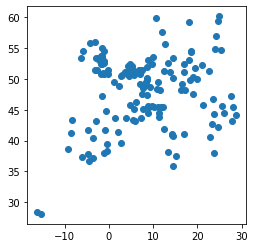

In [44]:
output_df.plot()

In [45]:
output_df.crs

<Geographic 2D CRS: EPSG:4258>
Name: ETRS89
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Moldova; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain; Sweden; Switzerland; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-16.1, 32.88, 40.18, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [48]:
output_df.rename(columns = {'Code_Country': 'CC'}, inplace = True)

In [49]:
fp = os.path.join(INDIR, "city_coordinates.shp")
# output_df.to_file(fp)

/Users/brecht/opt/anaconda3/envs/citynet/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
